In [0]:
# Mount Google Drive if working on Colab

from google.colab import drive
drive.mount("/drive")

In [0]:
# Install Pytesseract and Image Super Resolition (ISR) Library 

!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install ISR

In [0]:
# Import required packages

import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
from PIL import Image
import pytesseract as ocr
from ISR.models import RRDN
from google.colab.patches import cv2_imshow

In [0]:
# Load Pretrained ESRGAN Model

SR_Model = RRDN(weights='gans')

In [0]:
# Verhoeff Algorithm

multiplication_table = (
    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    (1, 2, 3, 4, 0, 6, 7, 8, 9, 5),
    (2, 3, 4, 0, 1, 7, 8, 9, 5, 6),
    (3, 4, 0, 1, 2, 8, 9, 5, 6, 7),
    (4, 0, 1, 2, 3, 9, 5, 6, 7, 8),
    (5, 9, 8, 7, 6, 0, 4, 3, 2, 1),
    (6, 5, 9, 8, 7, 1, 0, 4, 3, 2),
    (7, 6, 5, 9, 8, 2, 1, 0, 4, 3),
    (8, 7, 6, 5, 9, 3, 2, 1, 0, 4),
    (9, 8, 7, 6, 5, 4, 3, 2, 1, 0))

permutation_table = (
    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    (1, 5, 7, 6, 2, 8, 3, 0, 9, 4),
    (5, 8, 0, 3, 7, 9, 6, 1, 4, 2),
    (8, 9, 1, 6, 0, 4, 3, 5, 2, 7),
    (9, 4, 5, 3, 1, 2, 6, 8, 7, 0),
    (4, 2, 8, 6, 5, 7, 3, 9, 0, 1),
    (2, 7, 9, 3, 8, 0, 6, 4, 1, 5),
    (7, 0, 4, 6, 9, 1, 3, 2, 5, 8))

def compute_checksum(number):
    
    """Calculate the Verhoeff checksum over the provided number. The checksum
    is returned as an int. Valid numbers should have a checksum of 0."""
    
    # transform number list
    number = tuple(int(n) for n in reversed(str(number)))
    
    # calculate checksum
    checksum = 0
    
    for i, n in enumerate(number):
        checksum = multiplication_table[checksum][permutation_table[i % 8][n]]
    
    return checksum

In [0]:
# Search Possible UIDs with Bounding Boxes

def Regex_Search (result,bounding_boxes):

  start_char_pos = 0

  lines = result.split('\n')
  possible_UIDs = []

  for line in lines:
    
    words = line.split()

    if(len(words)==0):
      continue

    Combined = "".join(words)

    UID = re.search("[0-9]{4}\s[0-9]{4}\s[0-9]{4}",line)    

    if UID!=None:

      # Check Validity using Verhoeff Algo

      if compute_checksum(int(UID.group().replace(" ",""))) == 0:
        possible_UIDs.append([int(UID.group().replace(" ","")),
                              start_char_pos + UID.start() - line[:UID.start()].count(" ")]) 

    start_char_pos += len(Combined)

  possible_UIDs = np.array(possible_UIDs)
  return possible_UIDs

In [0]:
# Mask found UIDs using OpenCV

def Mask_UIDs (image_path,possible_UIDs,bounding_boxes,rtype,SR=False,SR_Ratio=[1,1]):

  img = cv2.imread(image_path)

  if rtype==2:
    img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)
  elif rtype==3:
    img = cv2.rotate(img,cv2.ROTATE_180)
  elif rtype==4:
    img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)

  height = img.shape[0]

  if SR==True:
    height*=SR_Ratio[1]

  for UID in possible_UIDs:

    digit1 = bounding_boxes[UID[1]].split()
    digit8 = bounding_boxes[UID[1] + 7].split()

    if SR==False:
      top_left_corner = (int(digit1[1]),height-int(digit1[4]))
      bottom_right_corner = (int(digit8[3]),height-int(digit1[2]))

    else:
      top_left_corner = (int(int(digit1[1])/SR_Ratio[0]),int((height-int(digit1[4]))/SR_Ratio[1]))
      bottom_right_corner = (int(int(digit8[3])/SR_Ratio[0]),int((height-int(digit1[2]))/SR_Ratio[1]))

    img = cv2.rectangle(img,top_left_corner,bottom_right_corner,(0,0,0),-1)

  if rtype==2:
    img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
  elif rtype==3:
    img = cv2.rotate(img,cv2.ROTATE_180)
  elif rtype==4:
    img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)

  file_name = image_path.split('/')[-1].split('.')[0]+"_masked"+"."+image_path.split('.')[-1]
  cv2.imwrite(file_name,img)
  return file_name

In [0]:
# Extract, Verify and Mask UIDs

def Extract_and_Mask_UIDs (image_path,SR=False,sr_image_path=None,SR_Ratio=[1,1]):

  if SR==False:
    img = cv2.imread(image_path)
  else:
    img = cv2.imread(sr_image_path)

  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  rotations = [[gray,1],
               [cv2.rotate(gray,cv2.ROTATE_90_COUNTERCLOCKWISE),2],
               [cv2.rotate(gray,cv2.ROTATE_180),3],
               [cv2.rotate(gray,cv2.ROTATE_90_CLOCKWISE),4]]

  settings = ('-l eng --oem 3 --psm 11')

  for rotation in rotations :
    
    cv2.imwrite('rotated_grayscale.png',rotation[0])
    result = ocr.image_to_string(Image.open('rotated_grayscale.png'),config=settings)
    bounding_boxes = ocr.image_to_boxes(Image.open('rotated_grayscale.png'),config=settings).split(" 0\n")

    possible_UIDs = Regex_Search(result,bounding_boxes)

    if len(possible_UIDs)==0:
      continue
    else:

      if SR==False:
        masked_img = Mask_UIDs (image_path,possible_UIDs,bounding_boxes,rotation[1])
      else:
        masked_img = Mask_UIDs (image_path,possible_UIDs,bounding_boxes,rotation[1],True,SR_Ratio)

      return (masked_img,possible_UIDs)

  return None

In [83]:
# Test on an Image

input_path = "/drive/My Drive/Flipr/data/4.TIF"   # Path to the Input Image
masked_img,possible_UIDs = Extract_and_Mask_UIDs(input_path)

if masked_img==None:
  print("Can't find any UID!")
else:
  print("Found UIDs : "+str(possible_UIDs[:,0]))

Found UIDs : [811235825105 811235825105]


In [0]:
# If it doesn't work, Try on Super Resolution Version 

input_path = "/drive/My Drive/Flipr/data/4.TIF"   # Path to the Input Image

# Super Resolution using ESRGAN

LR_img = cv2.imread(input_path)

SR_img = SR_Model.predict(LR_img[:,:,::-1])
cv2.imwrite("SR_img.png",SR_img[:,:,::-1])

SR_Ratio = [int(SR_img.shape[1]/LR_img.shape[1]),int(SR_img.shape[0]/LR_img.shape[0])]
masked_img,possible_UIDs = Extract_and_Mask_UIDs(input_path,True,"SR_img.png",SR_Ratio)

if masked_img==None:
  print("Can't find any UID!")
else:
  print("Found UIDs : "+str(possible_UIDs[:,0]))

Original :


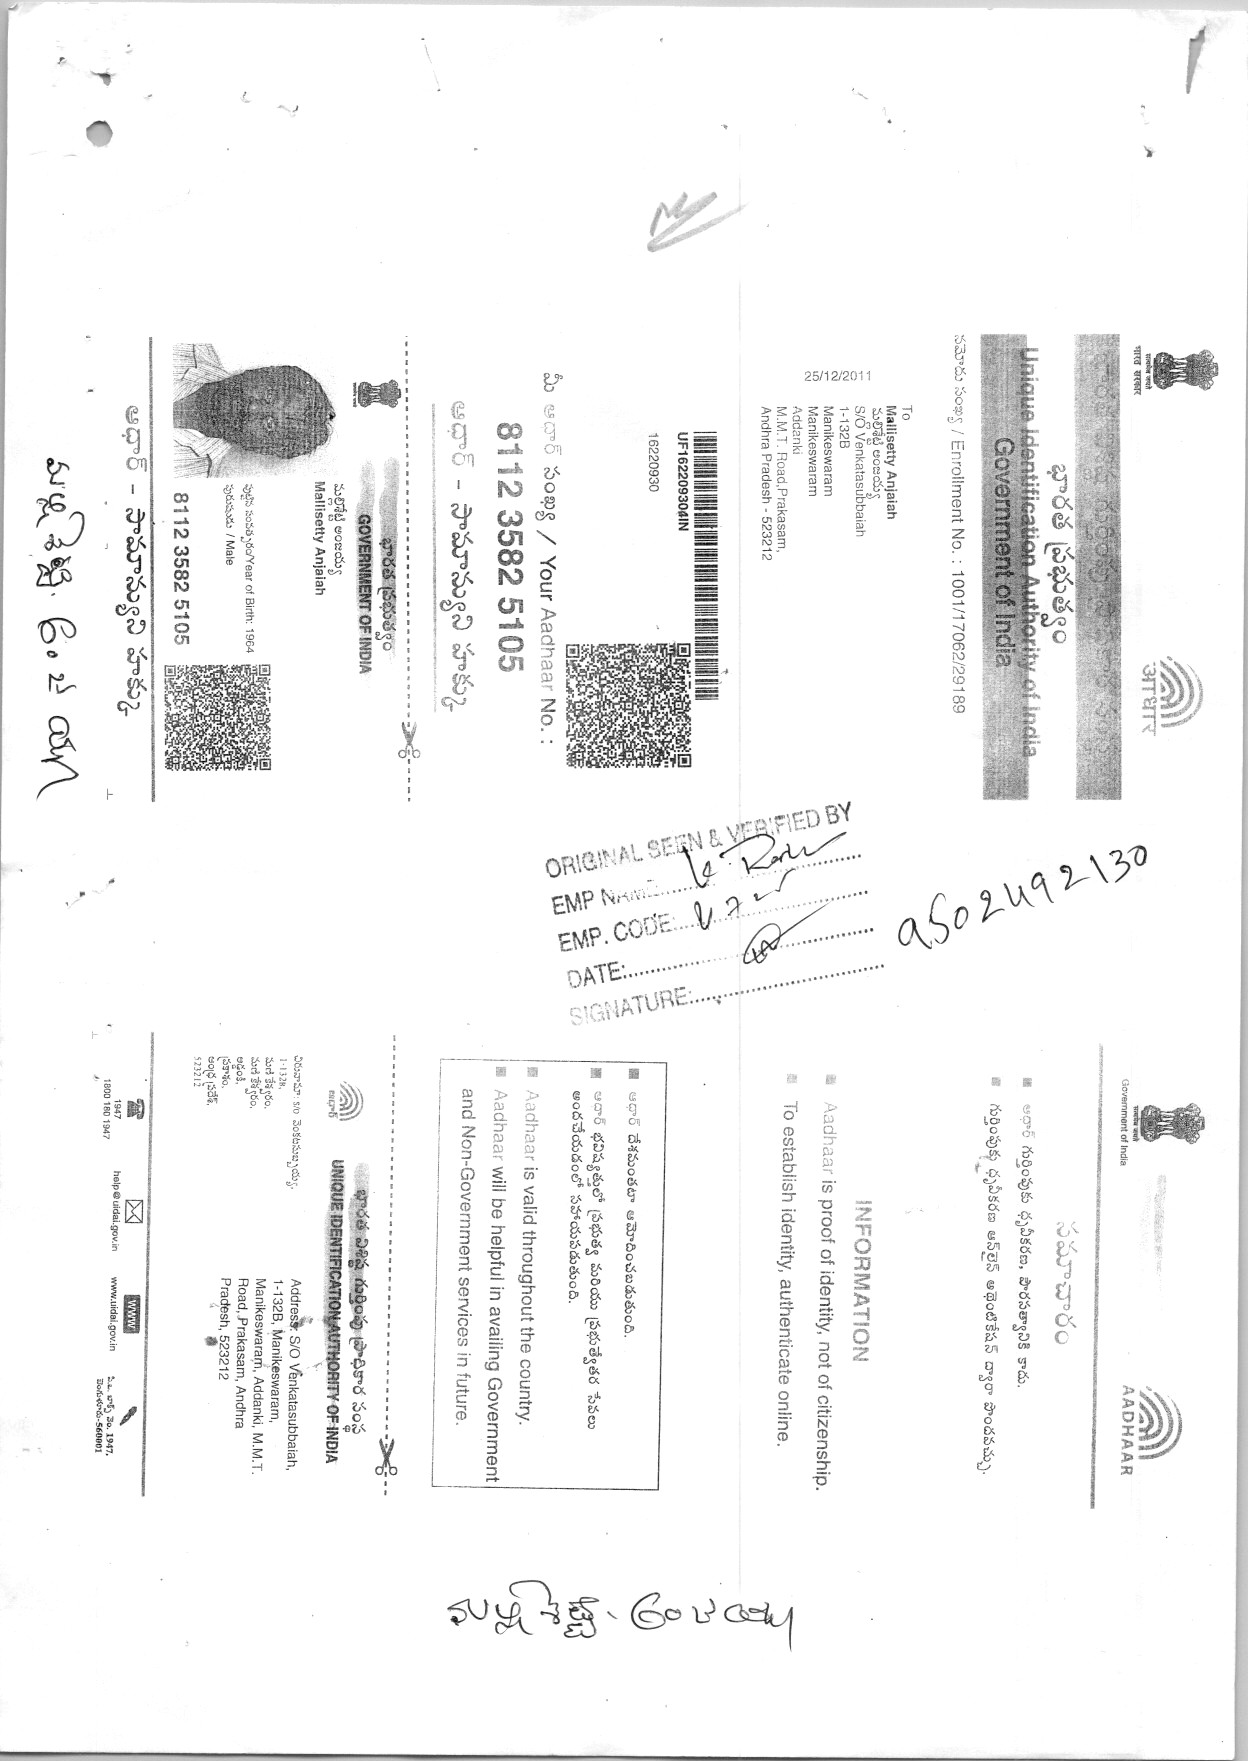


Masked :


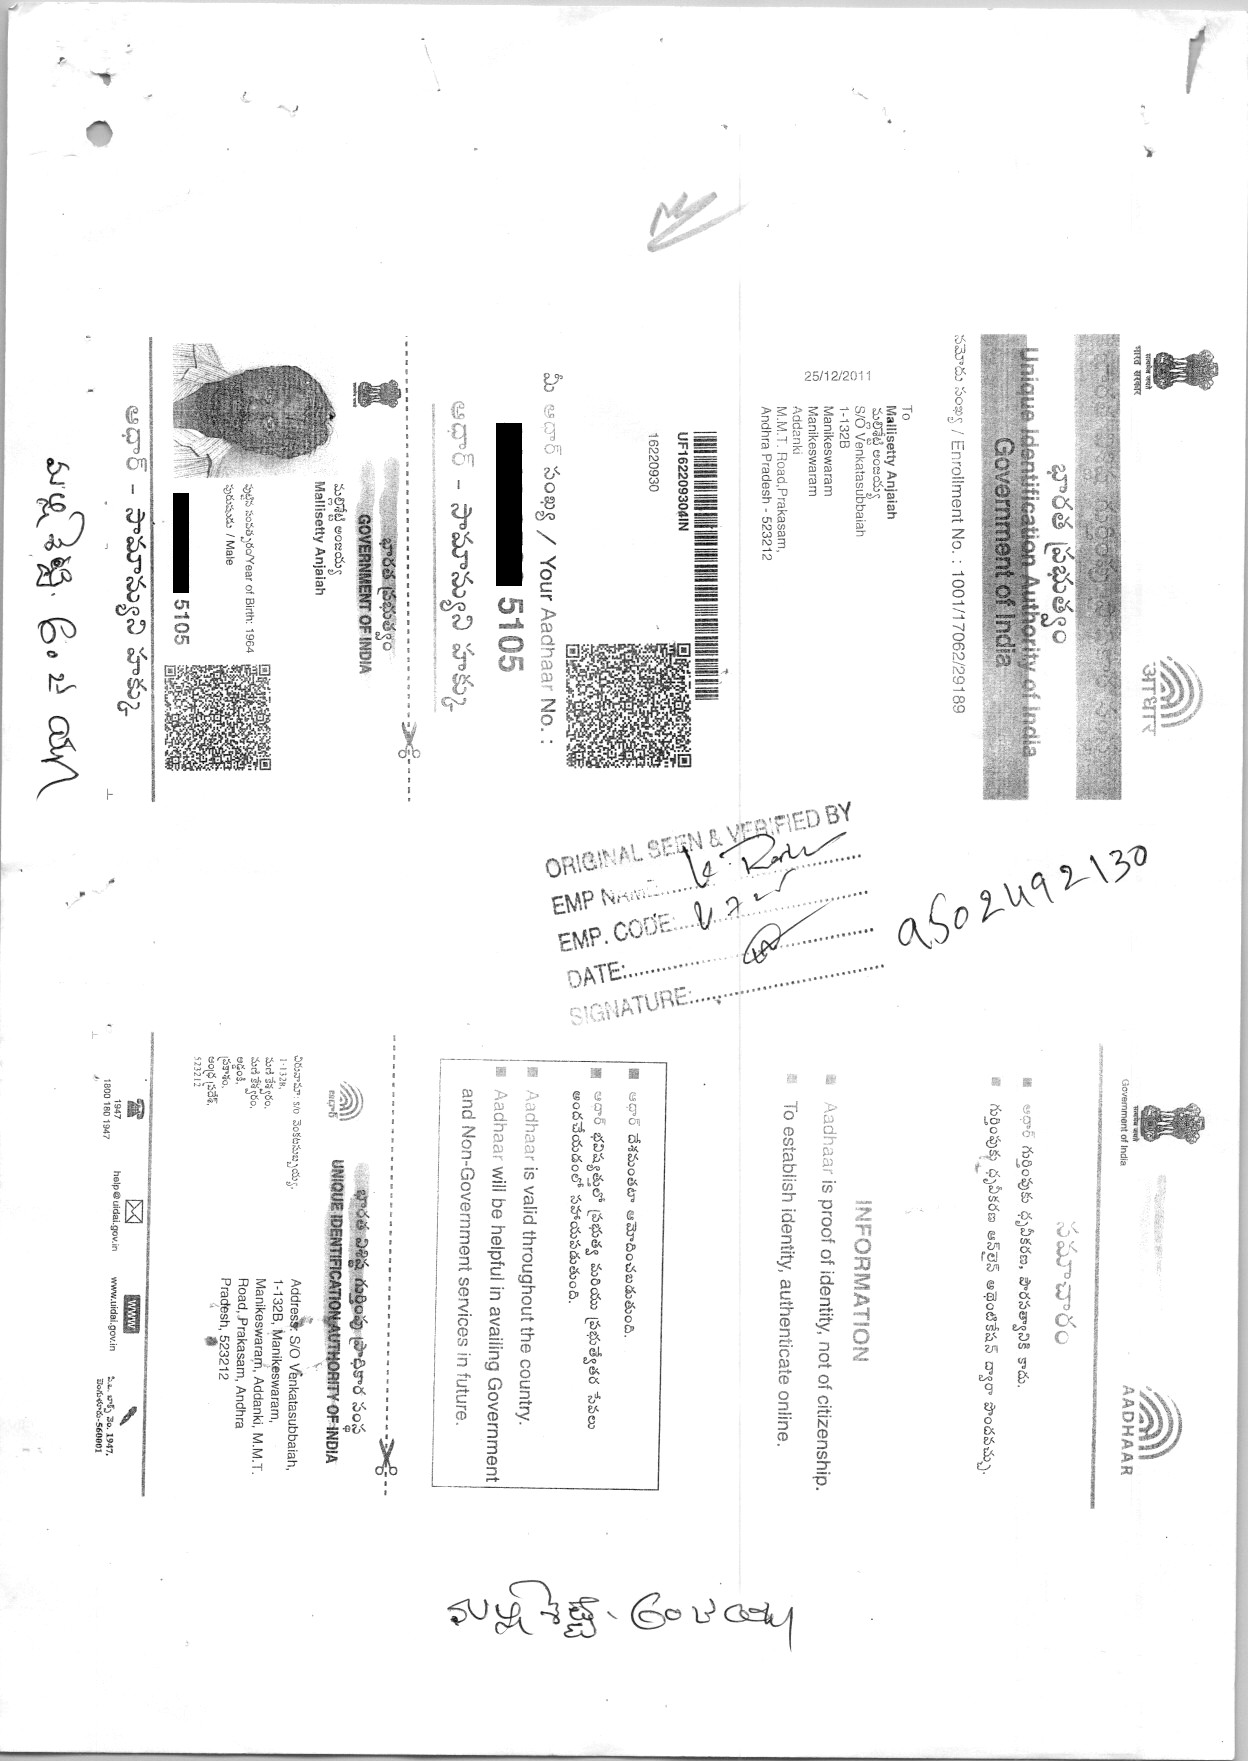

In [84]:
# Show Original and Masked Images

print("Original :")
cv2_imshow(cv2.imread(input_path))
print("\nMasked :")
cv2_imshow(cv2.imread(masked_img))

In [0]:
# Download Masked Image (if required)

from google.colab import files
files.download(masked_img)